# Подготовка к работе

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve

import warnings
RAND = 10
warnings.filterwarnings("ignore");

# Загрузка данных

In [127]:
X = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv")

In [35]:
df = X.join(y)
df.sample(3)

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,target
13286,0.042609,27,0,0.172900,6123.754877,14,0,2,0,0.0,0
52975,0.635244,43,0,0.297026,7762.894719,9,0,2,0,2.0,0
67247,0.016390,68,0,1.286887,1028.136235,20,0,3,0,0.0,0


In [3]:
X.shape

(105109, 10)

In [4]:
y.shape

(105109, 1)

In [5]:
X.sample(5)

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
103906,0.026817,81,0,172.952808,NaN,15,0,1,0,2.0
35371,0.548891,77,0,0.592528,2870.009966,5,0,0,0,0.0
82161,0.123863,44,0,0.505352,2902.980919,14,0,1,0,0.0
75255,0.199045,40,0,439.663299,NaN,9,0,0,0,0.0
61908,0.121055,44,0,0.543856,3909.853088,8,0,2,0,3.0


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105109 entries, 0 to 105108
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   credit_card_utilization     105109 non-null  float64
 1   age                         105109 non-null  int64  
 2   overdue_30_59_days          105109 non-null  int64  
 3   debt_to_income              105109 non-null  float64
 4   monthly_income              84116 non-null   float64
 5   credits_loans               105109 non-null  int64  
 6   overdue__more_than_90_days  105109 non-null  int64  
 7   mortgage_loans              105109 non-null  int64  
 8   overdue_60_89_days          105109 non-null  int64  
 9   family_members              102304 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 8.0 MB


In [14]:
X.monthly_income.isna().sum() / X.shape[0] 

0.19972599872513297

In [16]:
X.family_members.isna().sum() / X.shape[0] 

0.026686582500071356

In [7]:
X.nunique()

credit_card_utilization        97475
age                               86
overdue_30_59_days                15
debt_to_income                102217
monthly_income                 82956
credits_loans                     59
overdue__more_than_90_days        16
mortgage_loans                    27
overdue_60_89_days                13
family_members                    13
dtype: int64

In [10]:
X.describe()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
count,105109.000000,105109.000000,105109.000000,105109.000000,8.411600e+04,105109.000000,105109.000000,105109.000000,105109.000000,102304.000000
mean,5.825173,53.321067,0.426643,354.188156,6.649725e+03,8.956255,0.269967,1.018514,0.244356,0.757096
std,251.021431,14.811007,4.251225,1827.184165,1.106504e+04,5.182715,4.227366,1.136228,4.214018,1.116525
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029592,42.000000,0.000000,0.173670,3.343201e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153792,53.000000,0.000000,0.365047,5.361778e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.554374,64.000000,0.000000,0.880882,8.207866e+03,12.000000,0.000000,2.000000,0.000000,1.000000
max,48779.730023,111.000000,98.000000,323248.210242,1.359526e+06,58.000000,98.000000,54.000000,98.000000,20.000000


# Анализ данных

### Гипотезы
* Доход "хороших" заемщиков больше, по сравнению с "плохими" (распределения дохода в зависимости от флага дефолта смещено в большую сторону при default=0)
* Чем старше человек,тем ниже возвратность, так как он умирает не успев расплатиться
* когда много кредитов или высокая утилизация карт, чуваки не дефолтят, так как самофондируются другими кредитами
* те у кого ипотека - парни понадежнее
* размер долга влияет на выплату кредита
* если доход 0, сильно выше шанс невыплаты кредита
* утилизация кредитных карт сильно влияет на возвратность




#### Проверка дохода

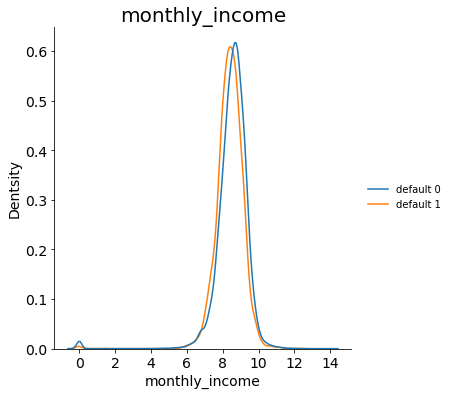

In [37]:
df["_monthly_incomelog"] = np.log(df.monthly_income)

sns.displot(
    {
        "default 0": df[df.target == 0]._monthly_incomelog,
        "default 1": df[df.target == 1]._monthly_incomelog
    },
    kind = "kde",
    common_norm=False
)
plt.title('monthly_income', fontsize=20)
plt.xlabel('monthly_income', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Вообще никакой разницы, теоретически можно убрать этот показатель

#### Проверка возраста

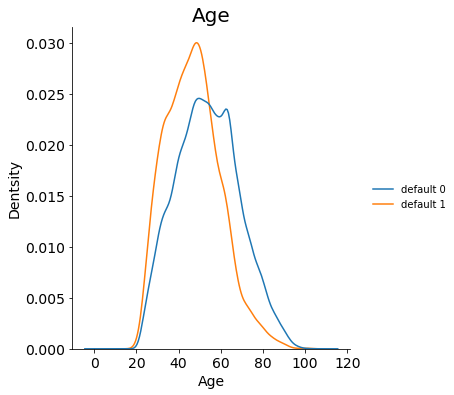

In [18]:
sns.displot(
    {
        "default 0": df[df.target == 0].age,
        "default 1": df[df.target == 1].age
    },
    kind = "kde",
    common_norm=False
)
plt.title('Age', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Есть подозрение, что после определенного возраста не выдают кредиты, тк правая часть графика 
очень похожа на левую часть, где не выдают кредиты до 21 года. Но так как нет дат выдачи, можно не проверять 

Но кажется, что старые платят лучше

### Проверка количества кредитов

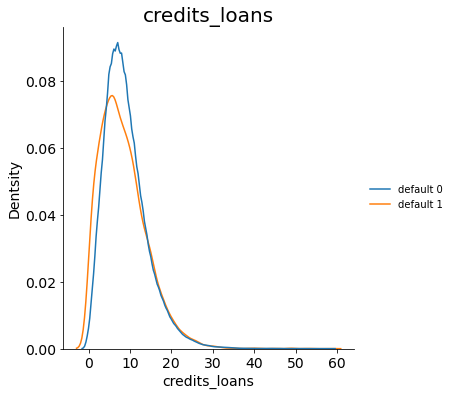

In [41]:
sns.displot(
    {
        "default 0": df[df.target == 0].credits_loans,
        "default 1": df[df.target == 1].credits_loans
    },
    kind = "kde",
    common_norm=False
)
plt.title('credits_loans', fontsize=20)
plt.xlabel('credits_loans', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

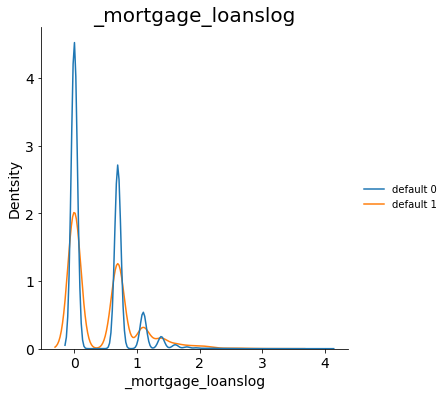

In [44]:
df['_mortgage_loanslog'] = np.log(df.mortgage_loans)
sns.displot(
    {
        "default 0": df[df.target == 0]._mortgage_loanslog,
        "default 1": df[df.target == 1]._mortgage_loanslog
    },
    kind = "kde",
    common_norm=False
)
plt.title('_mortgage_loanslog', fontsize=20)
plt.xlabel('_mortgage_loanslog', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Размер долга

In [49]:
df['_debt'] = df.debt_to_income * (df.monthly_income * 12) # Получаются очень маленькие числа, очевидно расчет шел от года
df.sample(10)

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,target,_monthly_incomelog,_mortgage_loanslog,_debt
16827,0.489541,64,1,2.095962,15434.118275,31,0,2,1,1.0,0,9.644336,0.693147,388191.890904
41160,0.478751,45,3,0.324620,5615.241240,9,2,1,2,1.0,0,8.633240,0.000000,21873.860360
102752,0.228691,64,0,0.345888,7463.334668,16,0,1,0,3.0,0,8.917758,0.000000,30977.765409
65082,0.028814,54,0,0.619527,9856.662525,13,0,3,0,1.0,1,9.195903,1.098612,73277.600812
58788,0.548023,56,1,0.264042,1381.429751,4,0,0,0,1.0,0,7.230874,-inf,4377.060662
45250,0.186372,65,0,0.397872,2684.455084,13,0,1,0,0.0,0,7.895233,0.000000,12816.826983
68660,0.204790,54,0,0.333855,4222.011511,12,0,1,0,2.0,0,8.348067,0.000000,16914.466825
8989,0.990179,29,0,0.051010,6465.702639,1,1,0,0,0.0,1,8.774267,-inf,3957.775597
102418,0.307678,53,0,1.352378,981.712365,7,0,1,0,2.0,0,6.889298,0.000000,15931.753887
40910,0.365214,49,0,0.364731,13341.812071,14,0,3,0,2.0,1,9.498658,1.098612,58394.004901


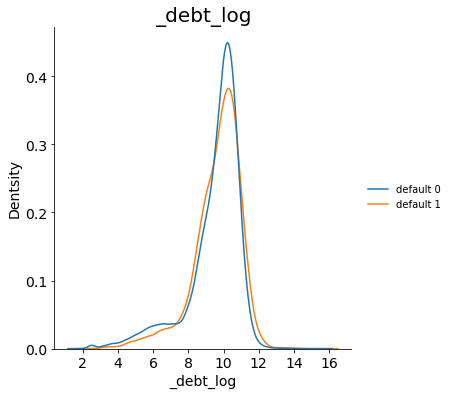

In [51]:
df['_debt_log'] = np.log(df._debt)
sns.displot(
    {
        "default 0": df[df.target == 0]._debt_log,
        "default 1": df[df.target == 1]._debt_log
    },
    kind = "kde",
    common_norm=False
)
plt.title('_debt_log', fontsize=20)
plt.xlabel('_debt_log', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [88]:
X_mod = X.sort_values(by = ["monthly_income"])
X_mod.head() # Почему у нищебродов D/I не 0. Берется средее? Показатель дохода не актуален? Берется средний годовой показатель дохода?

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
52549,0.084998,24,0,2213.015204,0.0,5,0,1,0,0.0
36016,0.000000,29,0,506.503879,0.0,3,0,0,0,1.0
21243,0.810952,38,0,2272.536202,0.0,4,0,1,0,0.0
92988,0.649289,52,0,4371.100602,0.0,10,0,1,0,2.0
11353,0.000000,32,0,1550.628741,0.0,3,0,1,0,0.0


### What is overdue

In [208]:
df['count'] = df.index
df.groupby('overdue_30_59_days')['count'].nunique() / df.shape[0]


overdue_30_59_days
0     0.839709
1     0.107155
2     0.030759
3     0.011626
4     0.004995
5     0.002293
6     0.000970
7     0.000352
8     0.000162
9     0.000076
10    0.000038
11    0.000010
12    0.000010
96    0.000048
98    0.001798
Name: count, dtype: float64

In [207]:
df['count'] = df.index
df.groupby('overdue__more_than_90_days')['count'].nunique() / df.shape[0]


overdue__more_than_90_days
0     0.944943
1     0.034459
2     0.010332
3     0.004386
4     0.001988
5     0.000942
6     0.000457
7     0.000228
8     0.000171
9     0.000124
10    0.000038
11    0.000029
12    0.000019
13    0.000038
96    0.000048
98    0.001798
Name: count, dtype: float64

### Corr

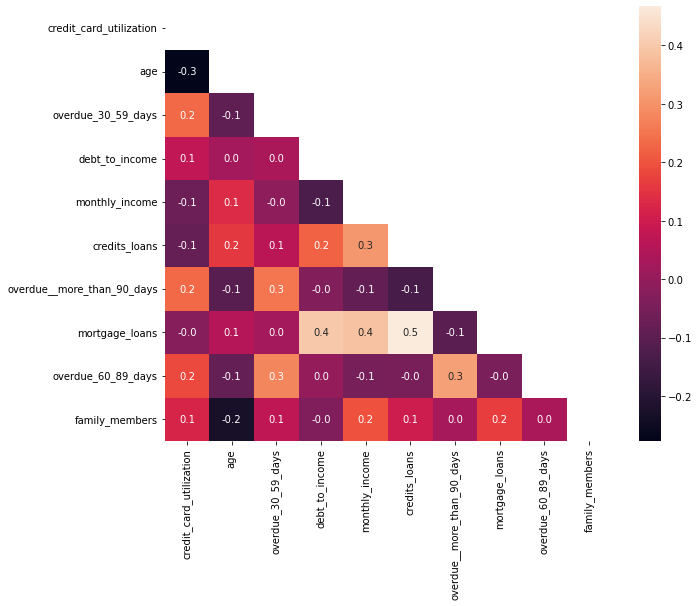

In [97]:
cor_matrix = np.triu(X.corr(method='spearman'))
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(method='spearman'), mask = cor_matrix,  annot=True, fmt=".1f");

Мультиколлинеарности не выявленоmь

## Заполняем пропуски

### Доход

In [110]:
X.loc[:,['monthly_income', 'family_members']].describe()

,monthly_income,family_members
count,8.411600e+04,102304.000000
mean,6.649725e+03,0.757096
std,1.106504e+04,1.116525
min,0.000000e+00,0.000000
25%,3.343201e+03,0.000000
50%,5.361778e+03,0.000000
75%,8.207866e+03,1.000000
max,1.359526e+06,20.000000


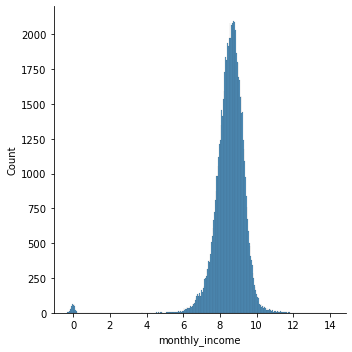

In [112]:
sns.displot(np.log(X['monthly_income']))

In [152]:
X['monthly_income'].fillna(np.mean(X[X['monthly_income'] > 0]['monthly_income']), inplace=True) # Заполняем средним от ненулевых значений

### Количество людей в семье

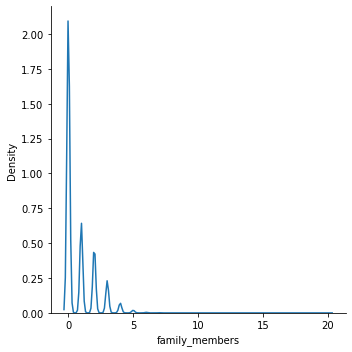

In [136]:
sns.displot((X['family_members']),kind = "kde",common_norm=False)

In [120]:
X.family_members.median()

0.0

In [121]:
X.family_members.mode()

0    0.0
dtype: float64

In [122]:
X.family_members.mean()

0.7570964967156709

In [154]:
X['family_members'].fillna(0, inplace=True) # Заполняем средним от ненулевых значений

In [155]:
X.isna().sum()

credit_card_utilization       0
age                           0
overdue_30_59_days            0
debt_to_income                0
monthly_income                0
credits_loans                 0
overdue__more_than_90_days    0
mortgage_loans                0
overdue_60_89_days            0
family_members                0
dtype: int64

# Логистическая регрессия

## Не серьезная

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify = y, shuffle = True, random_state = RAND)

In [158]:
lr_lol = LogisticRegression(class_weight = 'balanced')
lr_lol.fit(X_train, y_train)

y_pred = lr_lol.predict(X_test)
y_score = lr_lol.predict_proba(X_test)[:,1]

In [164]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics['Lol_lr'] = (roc_auc_score(y_test, y_score),
precision_score(y_test, y_pred),
recall_score(y_test, y_pred),
f1_score(y_test, y_pred),
log_loss(y_test, y_pred))
metrics

,Lol_lr
roc-auc,0.811092
precision,0.270833
recall,0.554608
f1,0.363942
logloss,4.479422


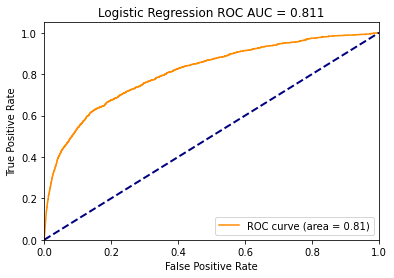

In [187]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

### Серьезная

In [168]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

In [174]:
%%time
#grid_cv.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.3 µs


In [172]:
grid_cv.best_params_

{'C': 500.5,
 'l1_ratio': 0.25,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [173]:
grid_cv.best_score_

0.8111756729505774

In [176]:
best_params = {'C': 500.5,
 'l1_ratio': 0.25,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [182]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train, y_train)

y_pred_gr = lr_gr.predict(X_test)
y_score_gr = lr_gr.predict_proba(X_test)[:,1]

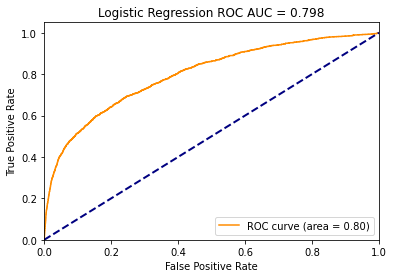

In [186]:
fpr, tpr, thresholds = roc_curve(y_test, y_score_gr)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [183]:
metrics['Serious_lr'] = (roc_auc_score(y_test, y_score_gr),
precision_score(y_test, y_pred_gr),
recall_score(y_test, y_pred_gr),
f1_score(y_test, y_pred_gr),
log_loss(y_test, y_pred_gr))
metrics

,Lol_lr,Serious_lr
roc-auc,0.811092,0.798317
precision,0.270833,0.233113
recall,0.554608,0.561433
f1,0.363942,0.329439
logloss,4.479422,5.281201


# Градиентный Бустинг

In [188]:
from xgboost import XGBClassifier
param_grid = {'max_depth': [2, 5, 10, 25],  # it was better
              'n_estimators': [5, 7, 10, 20]} 

grid = GridSearchCV(XGBClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 5, 'n_estimators': 20}


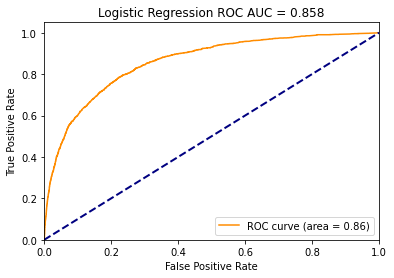

In [198]:
model = grid
preds = model.predict_proba(X_test)
preds2 = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [200]:
y_score_gr = lr_gr.predict_proba(X_test)[:,1]

metrics['XGB'] = (roc_auc,
precision_score(y_test, preds2),
recall_score(y_test, preds2),
f1_score(y_test, preds2),
log_loss(y_test, preds2))
metrics

,Lol_lr,Serious_lr,XGB
roc-auc,0.811092,0.798317,0.857869
precision,0.270833,0.233113,0.586466
recall,0.554608,0.561433,0.177474
f1,0.363942,0.329439,0.272489
logloss,4.479422,5.281201,2.189732


# Random Forest 

### Несерьезный

In [203]:
from sklearn.ensemble import RandomForestClassifier

In [210]:
model_forest = RandomForestClassifier(n_estimators = 100)
model_forest.fit(X_train, y_train)

RandomForestClassifier()

In [214]:
y_score_for = model_forest.predict_proba(X_test)[:,1]

In [219]:
fpr, tpr, thresholds = roc_curve(y_test, y_score_for)
roc_auc = auc(fpr, tpr)

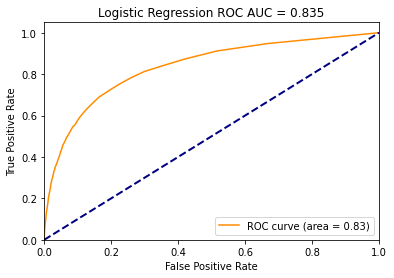

In [218]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [243]:
preds_forest = lr_gr.predict(X_test)
metrics['RF_lol'] = (roc_auc,
precision_score(y_test, preds_forest),
recall_score(y_test, preds_forest),
f1_score(y_test, preds_forest),
log_loss(y_test, preds_forest))


In [232]:
importances = model_forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [241]:
col = X_train.columns
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[0.2077, 'credit_card_utilization'],
 [0.1673, 'debt_to_income'],
 [0.143, 'monthly_income'],
 [0.1199, 'age'],
 [0.0915, 'overdue__more_than_90_days'],
 [0.0891, 'credits_loans'],
 [0.0537, 'overdue_60_89_days'],
 [0.0524, 'overdue_30_59_days'],
 [0.0401, 'family_members'],
 [0.0352, 'mortgage_loans']]

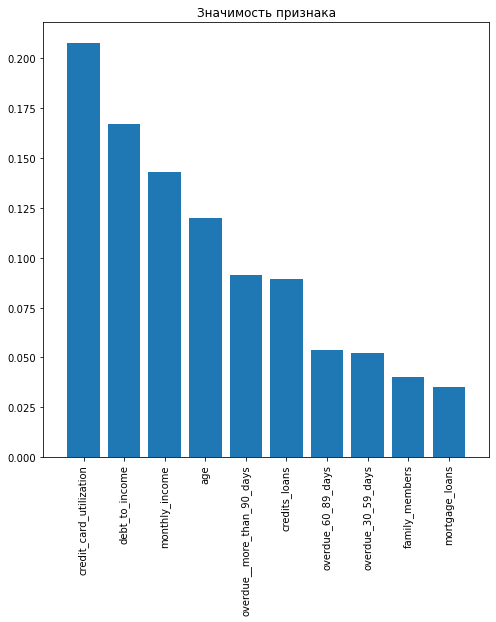

In [242]:
#диаграма 
d_first = len(col)
plt.figure(figsize=(8, 8))
plt.title("Значимость признака")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(col)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

## Hyperparameter tuning

In [253]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [260]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in the tree
max_depth = [2, 4]
# Minimum number of samles required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [261]:
random_grid = {'n_estimators' : n_estimators,
             'max_features' : max_features,
             'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap
             }

In [263]:
model_rfhp = RandomForestClassifier()

In [264]:
rf_frid = GridSearchCV(estimator = model_rfhp, param_grid = random_grid, cv = 3, verbose = 2, n_jobs = 4)

In [268]:
#rf_frid.fit(X_train, y_train)

In [266]:
rf_frid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 10}

In [267]:
RF_best_score = {'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 10}

In [271]:
y_score_forest = rf_frid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score_forest)
roc_auc = auc(fpr, tpr)

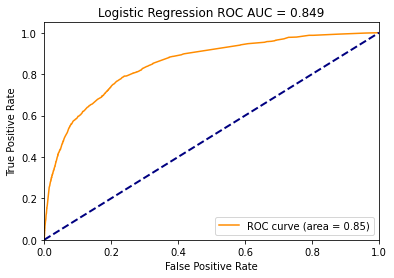

In [272]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [276]:
preds_forest_serious = rf_frid.predict(X_test)
metrics['RF_serious'] = (roc_auc,
precision_score(y_test, preds_forest_serious),
recall_score(y_test, preds_forest_serious),
f1_score(y_test, preds_forest_serious),
log_loss(y_test, preds_forest_serious))



In [277]:
metrics

,Lol_lr,Serious_lr,XGB,RF_base,RF_lol,RF_serious
roc-auc,0.811092,0.798317,0.857869,0.834593,0.834593,0.849458
precision,0.270833,0.233113,0.586466,0.233113,0.233113,0.598726
recall,0.554608,0.561433,0.177474,0.561433,0.561433,0.106940
f1,0.363942,0.329439,0.272489,0.329439,0.329439,0.181467
logloss,4.479422,5.281201,2.189732,5.281201,5.281201,2.229160
